In [3]:
import matplotlib.pyplot as plt
%notebook matplotlib

In [2]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0
Eager execution: True


In [5]:
# tf.GradientTape
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

dy_dx = tape.gradient(y, x)

dy_dx.numpy()

6.0

In [6]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 5s 0us/step


In [8]:
print(x_train.shape)
x_train[1,10:20,10:20]

(60000, 28, 28)


array([[0.93333333, 0.98823529, 0.98823529, 0.70196078, 0.04705882,
        0.29411765, 0.4745098 , 0.08235294, 0.        , 0.        ],
       [0.99215686, 0.91372549, 0.81568627, 0.32941176, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.94117647, 0.27843137, 0.0745098 , 0.10980392, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.24705882, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.02745098, 0.52941176],
       [0.        , 0.        , 0.       

In [9]:
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [10]:
x_train.shape

(60000, 28, 28, 1)

In [11]:
x_train[1,10:20,10:20,0]

array([[0.93333334, 0.9882353 , 0.9882353 , 0.7019608 , 0.04705882,
        0.29411766, 0.4745098 , 0.08235294, 0.        , 0.        ],
       [0.99215686, 0.9137255 , 0.8156863 , 0.32941177, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.9411765 , 0.2784314 , 0.07450981, 0.10980392, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.24705882, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.02745098, 0.5294118 ],
       [0.        , 0.        , 0.       

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices(
(x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [13]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [14]:
# Create an instance of the model
model = MyModel()

In [15]:
# Choose an optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [16]:
# Select metrics to measure the loss and the accuracy of the model.
# These metrics accumulate the values over epochs and then print the overall result

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [17]:
# tf.function Creates a callable TensorFlow graph from a Python function.
# 'function' constructs a callable that executes a TensorFlow graph
# ('tf.Graph') created by tracing the TensorFlow operations in 'func'.
# This allows the TensorFlow runtime to apply optimizations and exploit
# parallelism in the computation defined by 'func'

In [18]:
# Use tf.GradientTape to train the model
# Record operations for automatic differentiation

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True for train, training=False for test
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [20]:
# Test the model
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [21]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

In [22]:
EPOCHS = 10

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    # Resets all of the metric state variables.
    # This function is called between epochs/steps,
    # when a metric is evaluated during training
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    # Training loop - using batches of 32
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    msg_template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(msg_template.format(epoch + 1,
    train_loss.result(),
    train_accuracy.result() * 100,
    test_loss.result(),
    test_accuracy.result() * 100))

    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_accuracy.result())
    test_loss_results.append(test_loss.result())
    test_accuracy_results.append(test_accuracy.result())

Epoch 1, Loss: 0.13639232516288757, Accuracy: 95.9000015258789, Test Loss: 0.061364348977804184, Test Accuracy: 97.98999786376953
Epoch 2, Loss: 0.04273665323853493, Accuracy: 98.66166687011719, Test Loss: 0.05821870267391205, Test Accuracy: 97.95999908447266
Epoch 3, Loss: 0.022697510197758675, Accuracy: 99.25833129882812, Test Loss: 0.052708763629198074, Test Accuracy: 98.32999420166016
Epoch 4, Loss: 0.014552532695233822, Accuracy: 99.49500274658203, Test Loss: 0.06766004860401154, Test Accuracy: 98.32999420166016
Epoch 5, Loss: 0.010286570526659489, Accuracy: 99.66333770751953, Test Loss: 0.06821412593126297, Test Accuracy: 98.3699951171875
Epoch 6, Loss: 0.0070119379088282585, Accuracy: 99.76000213623047, Test Loss: 0.07975128293037415, Test Accuracy: 98.0999984741211
Epoch 7, Loss: 0.006088239140808582, Accuracy: 99.79833221435547, Test Loss: 0.08130480349063873, Test Accuracy: 98.18000030517578
Epoch 8, Loss: 0.005359577480703592, Accuracy: 99.82666015625, Test Loss: 0.087985530

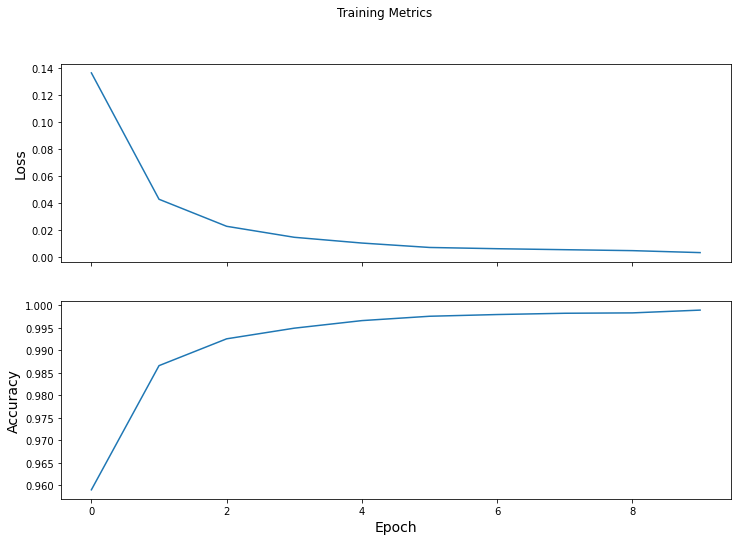

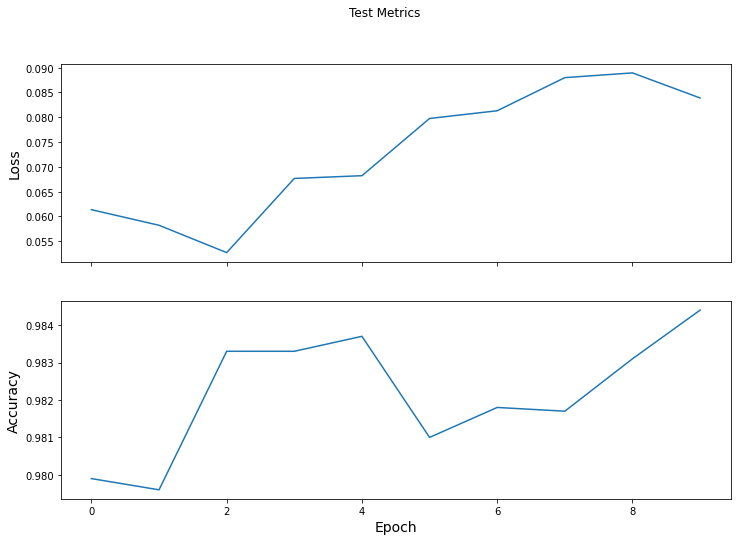

In [23]:
# plot
# Training
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

# Test
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Test Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(test_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()